In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pickle

from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import cifar10

# import parameters
#from model_params import *


Using TensorFlow backend.


In [2]:
img_rows, img_cols, img_chns = 32, 32, 3
latent_dim = 60
intermediate_dim = 512
epsilon_std = 1.0
epochs = 15
filters = 60
num_conv = 3
batch_size = 20

../img/Fall/cacharel/10.jpg


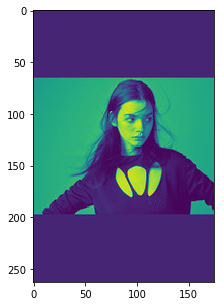

../img/Fall/a-w-a-k-e-/7.jpg


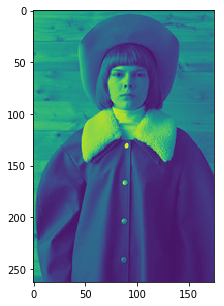

../img/Fall/a-w-a-k-e-/17.jpg


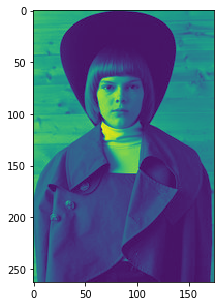

../img/Fall/a-w-a-k-e-/53.jpg


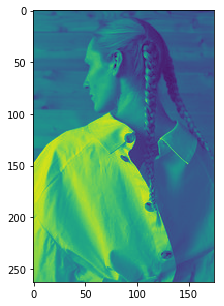

../img/Fall/a-w-a-k-e-/52.jpg


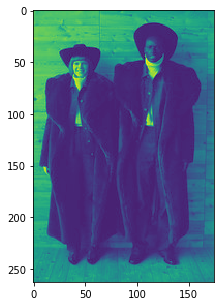

../img/Fall/a-w-a-k-e-/30.jpg


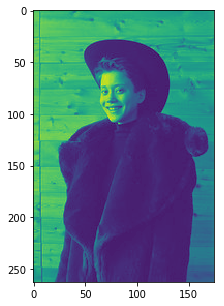

../img/Fall/a-w-a-k-e-/68.jpg


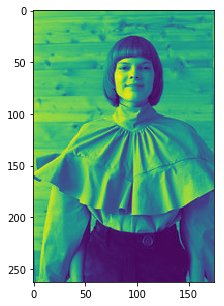

../img/Fall/a-w-a-k-e-/4.jpg


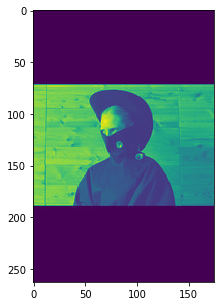

../img/Fall/a-w-a-k-e-/38.jpg


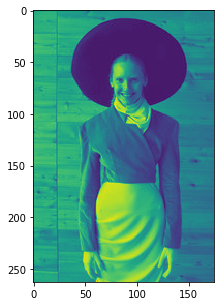

../img/Fall/a-w-a-k-e-/64.jpg


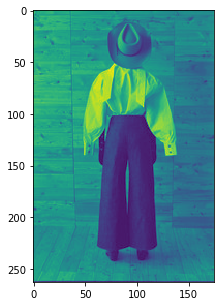

../img/Fall/a-w-a-k-e-/79.jpg


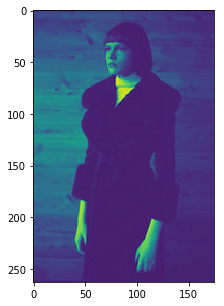

../img/Fall/a-w-a-k-e-/56.jpg


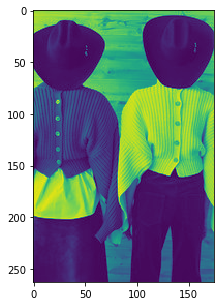

../img/Fall/a-w-a-k-e-#collection/7.jpg


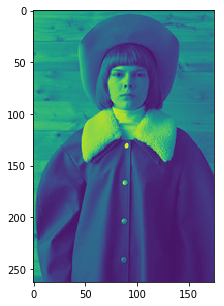

../img/Fall/a-w-a-k-e-#collection/17.jpg


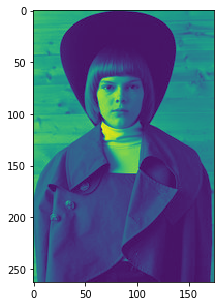

../img/Fall/a-w-a-k-e-#collection/30.jpg


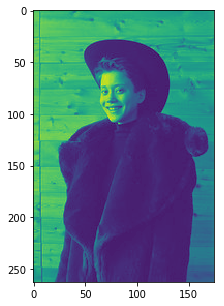

../img/Fall/a-w-a-k-e-#collection/4.jpg


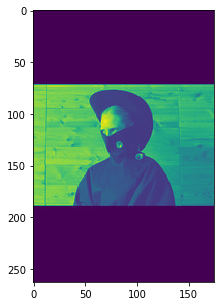

../img/Fall/a-w-a-k-e-#collection/38.jpg


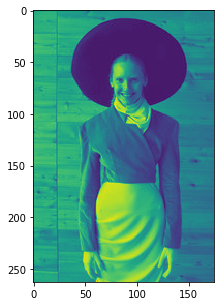

Input size (3867, 32, 32, 3)
(32, 32, 3)
(3093, 32, 32, 3)


In [3]:
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split

show_name = "Fall"
src_dir = "../img/%s" % show_name

input_files = []
for root, dirs, files in os.walk(src_dir):
    for f in files:
        if os.path.splitext(f)[-1].lower() in [".jpg", ".JPG"]:
            os.path.join(root, f)
            input_files.append(os.path.join(root, f))
            
#input_files = [os.path.join(src_dir, f) for f in os.listdir(src_dir) if f.endswith(".jpg")]
#imgs = [Image.open(im).convert('RGB').resize((172, 260), Image.ANTIALIAS) for im in input_files]
#lwf_immatrix = np.array([np.array(im) for im in imgs])

lwf_immatrix = []
for im in input_files:
    img = Image.open(im)
    if len(np.array(img).shape) != 3:
        print(im)
        plt.figure(figsize=(5, 5))
        plt.imshow(np.array(img))
        plt.show()
    else:
        #lwf_immatrix.append(np.array(img.resize((172, 260), Image.ANTIALIAS)))
        lwf_immatrix.append(np.array(img.resize((img_rows, img_cols), Image.ANTIALIAS))) # change in img_row! in the above cell

lwf_immatrix = np.array(lwf_immatrix)
        
    
#lwf_immatrix = np.array([np.array(Image.open(im)) for im in input_files])
print("Input size", lwf_immatrix.shape)

#plt.figure(figsize=(5, 5))
#plt.imshow(lwf_immatrix[0])
#plt.show()

x_train, x_test, _, _ = train_test_split(lwf_immatrix, [0]*len(lwf_immatrix), test_size=0.20, random_state=42)

original_img_size = lwf_immatrix[0].shape

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
print(original_img_size)
print(x_train.shape)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)

In [4]:
# tensorflow uses channels_last
# theano uses channels_first
"""
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)
"""
#original_img_size = (img_rows, img_cols, img_chns)

# encoder architecture
x = Input(shape=original_img_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

# mean and variance for latent variables
z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

# sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


# decoder architecture
decoder_hid = Dense(intermediate_dim, activation='relu')


decoder_upsample = Dense(int(filters * round(img_rows / 2) * round(img_cols / 2)), activation='relu')
output_shape = (batch_size, int(round(img_rows / 2)), int(round(img_cols / 2)), filters)

"""
decoder_upsample = Dense(16 * 16 * filters, activation='relu')
output_shape = (batch_size, 16, 16, filters)
"""

decoder_reshape = Reshape(output_shape[1:])
decoder_deconv_1 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                          kernel_size=(3, 3),
                                          strides=(2, 2),
                                          padding='valid',
                                          activation='relu')
decoder_mean_squash = Conv2D(img_chns,
                             kernel_size=2,
                             padding='valid',
                             activation='sigmoid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)


# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean_squash):
        x = K.flatten(x)
        x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
        xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean_squash)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean_squash = inputs[1]
        print(x)
        print(x_decoded_mean_squash)
        loss = self.vae_loss(x, x_decoded_mean_squash)
        print(loss)
        self.add_loss(loss, inputs=inputs)
        return x



def my_vae_loss(x, x_decoded_mean_squash):
    x = K.flatten(x)
    x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
    xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean_squash)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

vae = Model(x, x_decoded_mean_squash)
vae.compile(optimizer='Adam', loss=my_vae_loss)

# entire model
#y = CustomVariationalLayer()([x, x_decoded_mean_squash])
#vae = Model(x, y)
#vae.compile(optimizer='Adam', loss=None)
vae.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 3)    39          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 60)   780         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 16, 16, 60)   32460       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [5]:
# training
history = vae.fit(x_train,
                  x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=30,
        validation_data=(x_test, x_test))

# encoder from learned model
encoder = Model(x, z_mean)

# generator / decoder from learned model
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

# save all 3 models for future use - especially generator
vae.save('../models/cifar10_%d*%d_ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (img_rows, img_cols, latent_dim, num_conv, intermediate_dim, epochs))
encoder.save('../models/cifar10_%d*%d_ld_%d_conv_%d_id_%d_e_%d_encoder.h5' % (img_rows, img_cols, latent_dim, num_conv, intermediate_dim, epochs))
generator.save('../models/cifar10_%d*%d_ld_%d_conv_%d_id_%d_e_%d_generator.h5' % (img_rows, img_cols, latent_dim, num_conv, intermediate_dim, epochs))

# save training history
fname = '../models/cifar10_ld_%d*%d_%d_conv_%d_id_%d_e_%d_history.pkl' % (img_rows, img_cols, latent_dim, num_conv, intermediate_dim, epochs)
with open(fname, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Train on 3093 samples, validate on 774 samples
Epoch 1/15
3093/3093 [==============================] - 59s 19ms/step - loss: 639.7137 - val_loss: 596.4897
Epoch 2/15
3093/3093 [==============================] - 58s 19ms/step - loss: 580.3553 - val_loss: 578.1552
Epoch 3/15
3093/3093 [==============================] - 58s 19ms/step - loss: 569.3048 - val_loss: 573.3969
Epoch 4/15
3093/3093 [==============================] - 58s 19ms/step - loss: 563.0581 - val_loss: 567.0005
Epoch 5/15
3093/3093 [==============================] - 58s 19ms/step - loss: 557.1438 - val_loss: 561.6510
Epoch 6/15
3093/3093 [==============================] - 58s 19ms/step - loss: 552.4011 - val_loss: 557.6268
Epoch 7/15
3093/3093 [==============================] - 58s 19ms/step - loss: 548.7973 - val_loss: 555.6742
Epoch 8/15
3093/3093 [==============================] - 58s 19ms/step - loss: 546.0064 - val_loss: 553.9058
Epoch 9/15
3093/3093 [==============================] - 58s 19ms/step - loss: 543.7083 - 

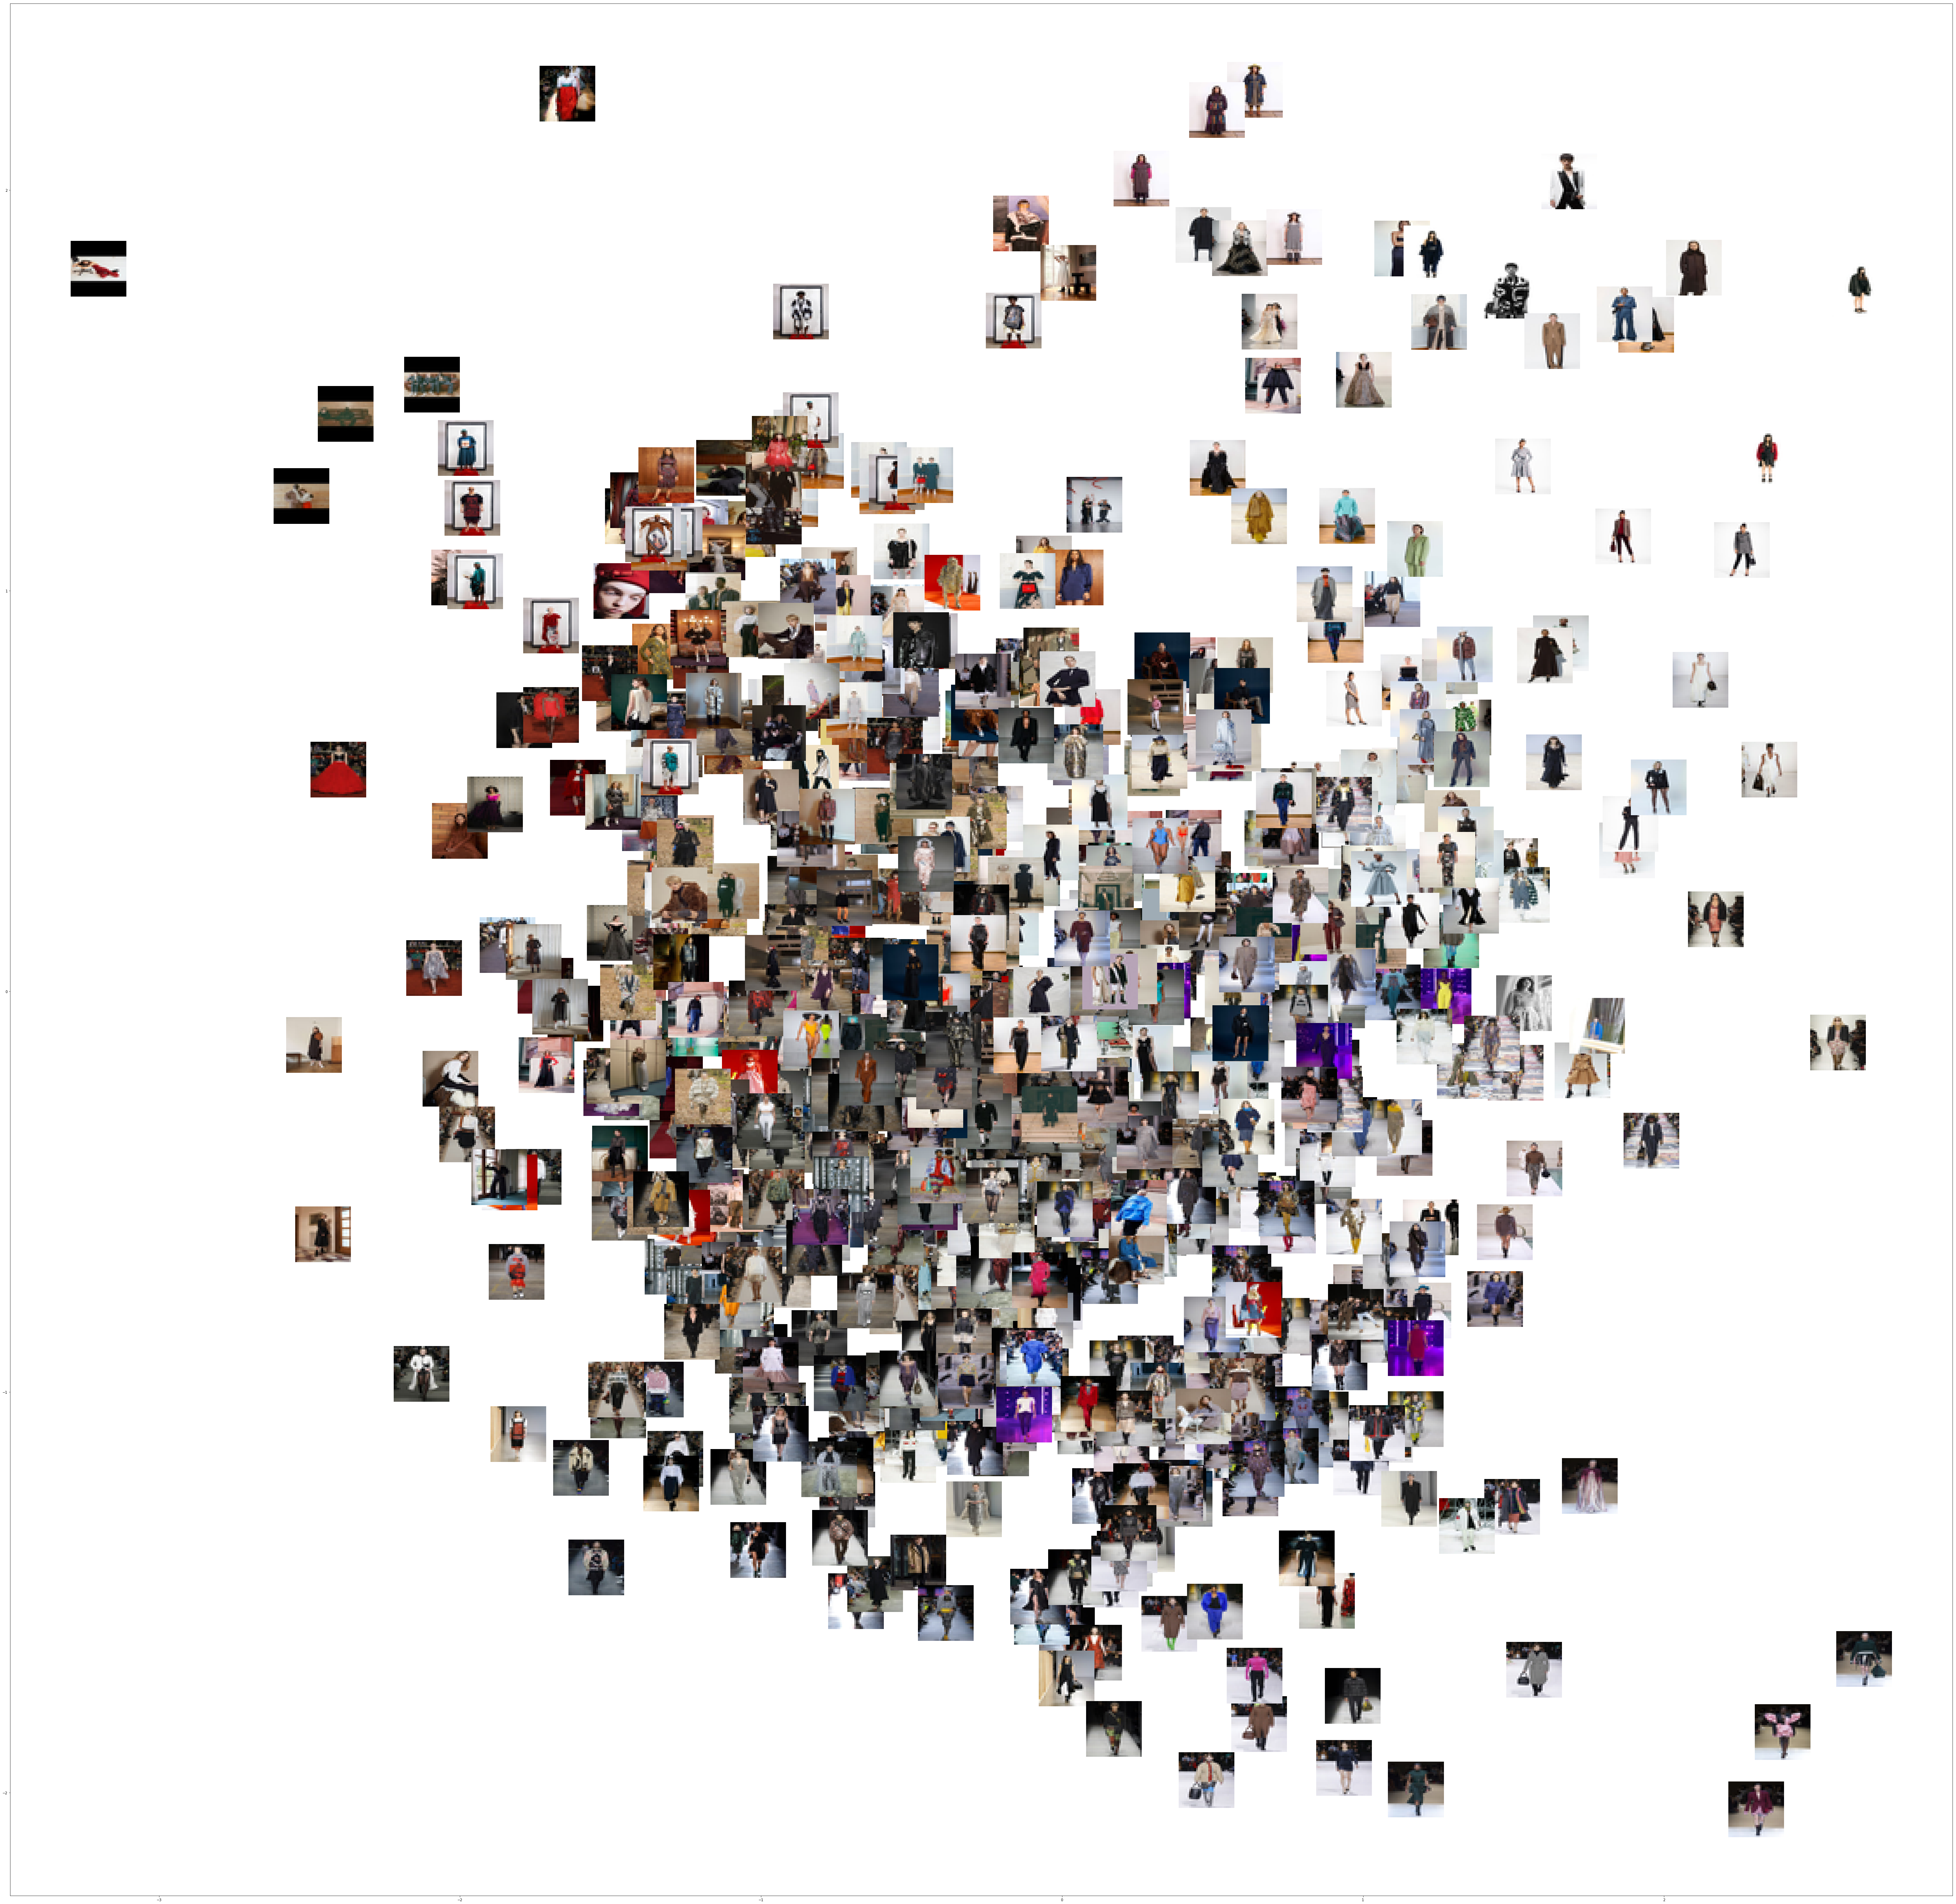

In [14]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


def getImage(img,zoom=5):
    return OffsetImage(img,zoom=zoom)

imgs = x_test
x = x_test_encoded[:, 0]
y = x_test_encoded[:, 1]

fig, ax = plt.subplots(figsize=(100, 100))
ax.scatter(x, y) 

artists = []
for x0, y0, img in zip(x, y, imgs):
    ab = AnnotationBbox(getImage(img), (x0, y0), frameon=False)
    artists.append(ax.add_artist(ab))

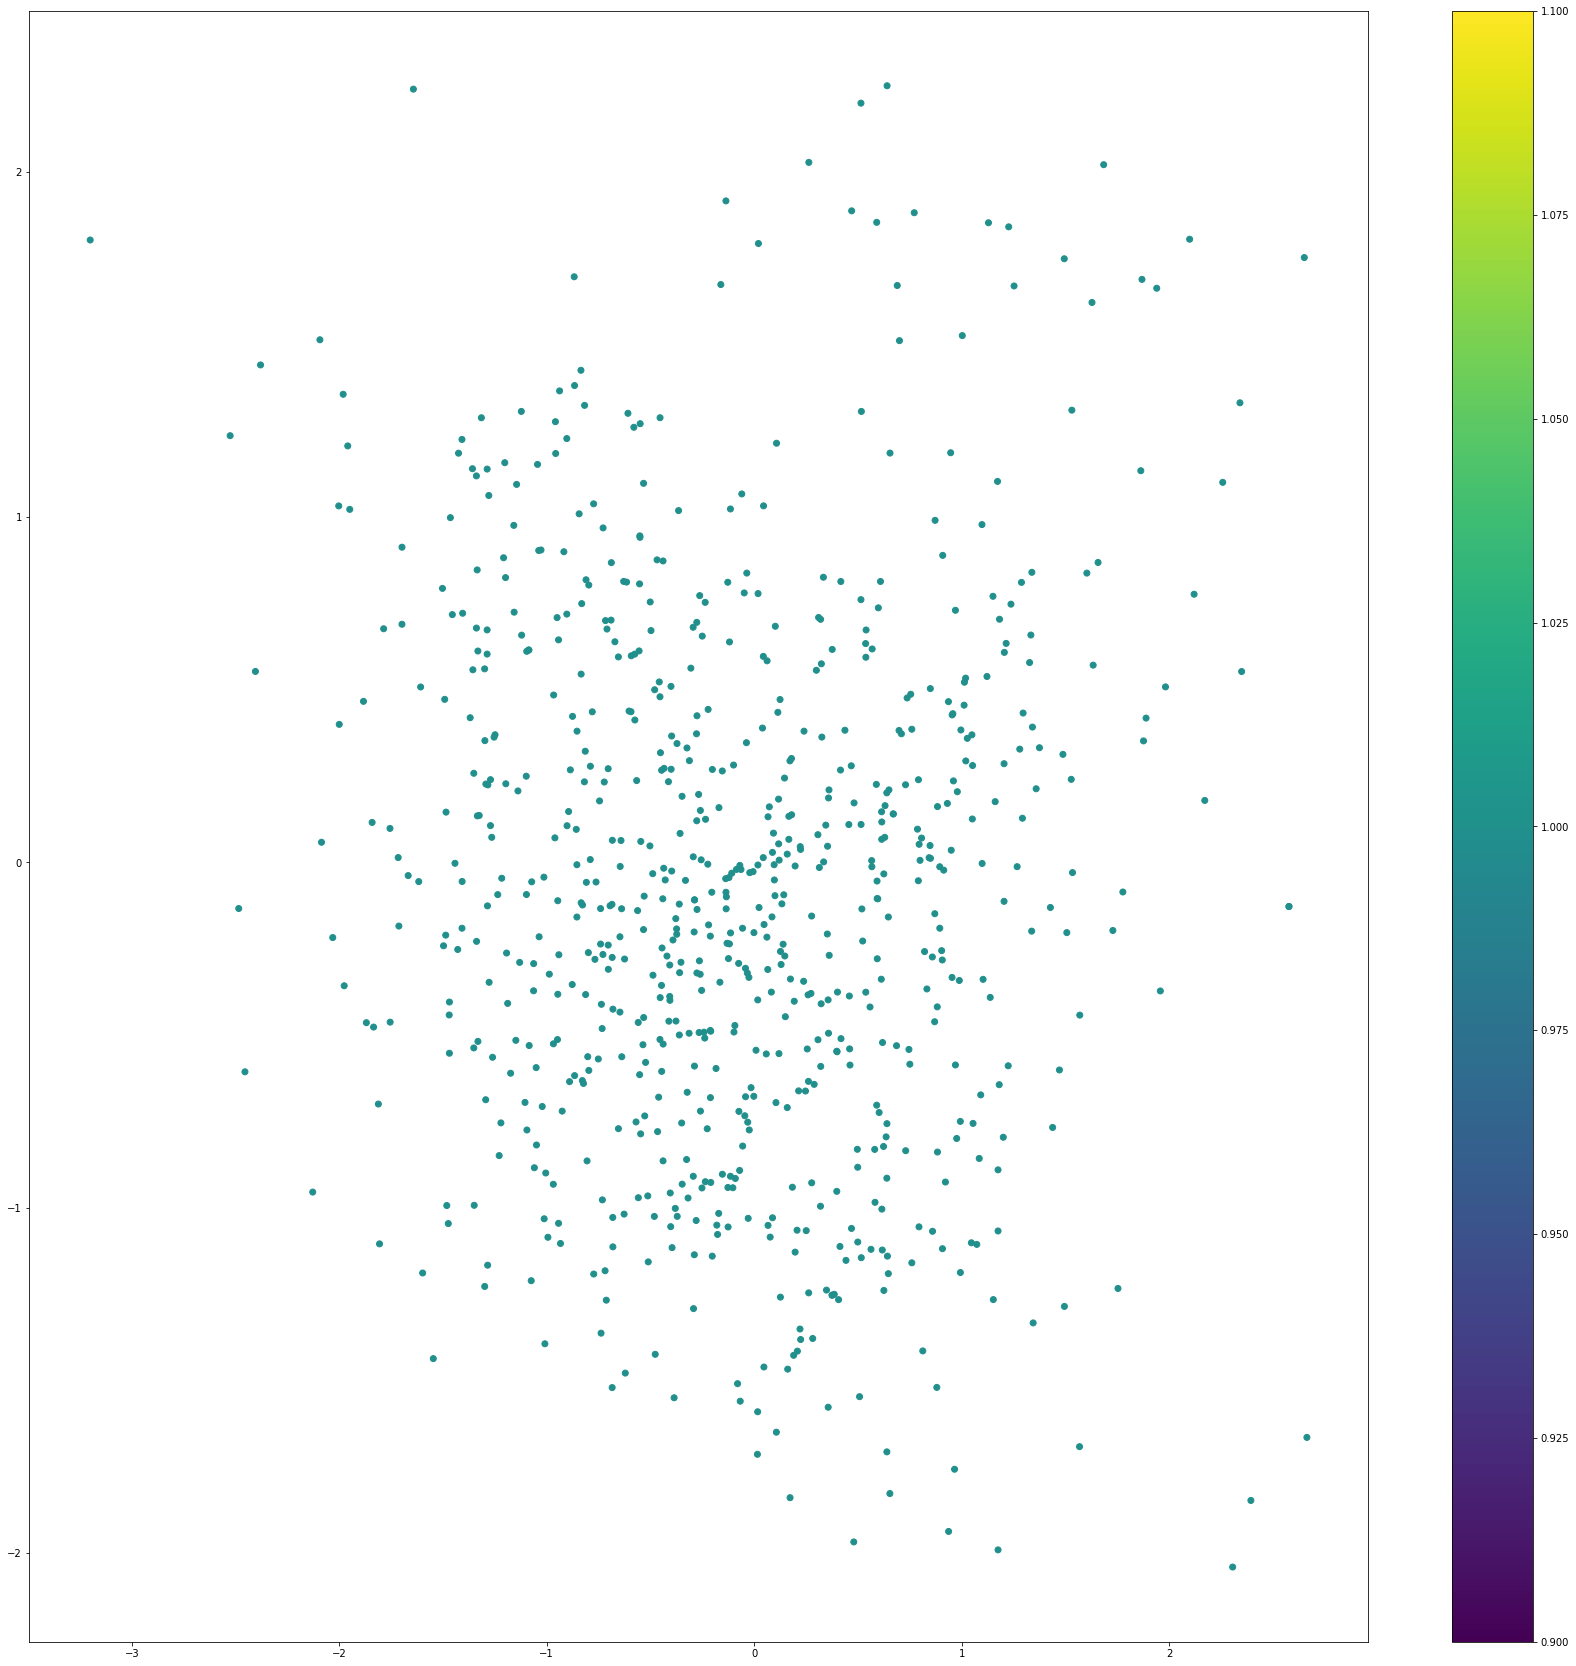

In [8]:
# display a 2D plot of the classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(30, 30))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=[1]*len(x_test))
plt.colorbar()
plt.show()

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import keras
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import cifar10
import pickle

if latent_dim == 3:
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1],x_test_encoded[:, 2], c=y_test)
    plt.show()

if latent_dim == 2:
    # display a 2D plot of the classes in the latent space
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(6, 6))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=[1]*len(x_test))
    plt.colorbar()
    plt.show()

    

[[ 0.01800689 -0.36524956 -0.89988701 -0.42693603  0.77629312 -0.57188396
   0.89764478  0.28563097 -0.47150593 -0.16801753 -0.97996655 -0.12103332
  -0.14184739  0.0918906  -0.67592133 -0.19171303  0.80940597  0.21259901
  -0.30691522  0.88267547  0.74867648 -0.65489986  0.11884265  0.49052968
  -0.01763929 -0.34622518 -0.91786861 -0.79008775 -0.19183628  0.14139827
   0.3528833  -0.4422098   0.16420353 -0.14280905 -0.80779906 -0.10794534
  -0.60293334 -0.88543739 -0.26389806  0.46535943  0.71793009 -0.26149425
   0.43530388  0.33500097  0.21762155 -0.87438834  0.5283087   0.84409224
   0.02379495  0.28099933 -0.79619914 -0.00665197 -0.98852465  0.7729274
   0.07217012 -0.27209523  0.47167988  0.44689838  0.17392295  0.86522041]] 1


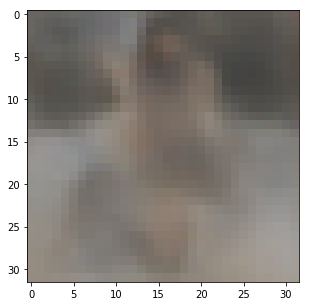

[[ 0.19649973  0.46035608  0.85324084 -0.325803   -0.3993279   0.04317509
  -0.47932656 -0.94259984 -0.66622726 -0.88065131  0.34368092  0.09958595
   0.43371536  0.19579737  0.70720136  0.47661521  0.08151661  0.62044463
   0.98615921  0.12679374 -0.42747261  0.91803512 -0.32986993 -0.52320682
   0.73283558  0.87960509 -0.62390793  0.43008073  0.67078334  0.98798356
   0.95133323 -0.31782432  0.0211021   0.42196702  0.73734801 -0.47611632
  -0.11278472 -0.29482857  0.10542138  0.14914785 -0.98658511  0.657694
   0.18105871  0.76112138 -0.5042496  -0.39046148 -0.91342571 -0.29518216
   0.42248127 -0.73491766 -0.55507868  0.52918987 -0.55921485 -0.55530352
  -0.74460696  0.1817441  -0.46804773 -0.77345206 -0.19754308  0.01871113]] 1


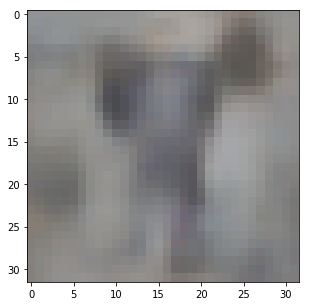

[[-0.7646886   0.4860919   0.24407423 -0.92425412  0.8857977   0.99788899
  -0.49145784  0.55558706 -0.5644899   0.36658558 -0.25585593  0.75572948
  -0.12741778  0.67456749 -0.52730319 -0.00546506  0.49153108 -0.1999247
  -0.60004241 -0.99335421  0.1376549   0.97509161  0.29795885  0.73802434
   0.0711544  -0.80395918 -0.91469743 -0.26715874  0.49812439  0.42924629
  -0.3054103   0.15139735 -0.02575944 -0.67253226 -0.57332221 -0.21614908
   0.25564344  0.06867423 -0.21923496 -0.64079715  0.54564313 -0.83488137
   0.87486868  0.76742134 -0.78068915 -0.03470457 -0.71189414  0.31961325
   0.80562302 -0.95235258  0.08413184 -0.63861896  0.00205836  0.32794938
   0.20892234 -0.65448466 -0.13408237  0.03259629  0.32984765 -0.4483527 ]] 1


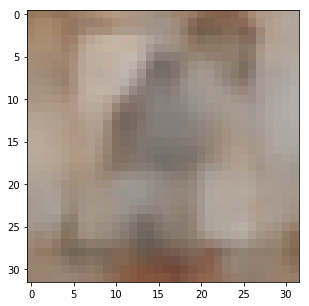

[[-0.6328362  -0.75863724  0.32345681 -0.48271096  0.78470898  0.60001679
  -0.65029614  0.30205935 -0.75597312 -0.48424067  0.51366949  0.11545473
   0.1203356  -0.09507022  0.46161018 -0.43549159 -0.05347127 -0.32616264
   0.69099409 -0.33405355 -0.51991522 -0.28526878 -0.24061895  0.3829083
   0.62851779  0.87016375 -0.47383357  0.84675385  0.30937689 -0.40914489
   0.83581487  0.84445896  0.66474516 -0.1688052  -0.22739925 -0.66422162
  -0.3527965   0.9853329  -0.74005618  0.91861235 -0.98810093  0.21920697
   0.14588451  0.15598646 -0.40610358  0.67430911  0.84188197  0.32584739
   0.63254315 -0.11338133  0.71399216  0.12231434 -0.55467782 -0.34604861
  -0.24423131 -0.33154037 -0.89896266 -0.12220163 -0.75105834  0.78130417]] 1


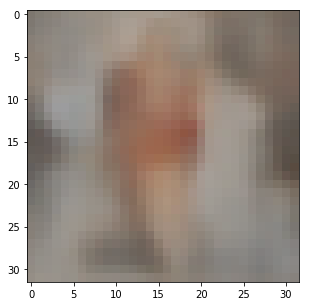

[[ 0.8670804   0.6994232   0.79785572 -0.63734301  0.30285749  0.02211085
   0.20022704  0.45010594 -0.13100744 -0.6449579  -0.54944591 -0.85395244
   0.86460495 -0.12614032  0.14216195  0.83378729  0.73670707 -0.15882532
  -0.40036145 -0.1631591   0.3085326   0.76083085  0.88137842 -0.62846397
  -0.1845675   0.03630342 -0.94733285 -0.37471843 -0.27384995  0.288678
   0.12707026 -0.96456209  0.63124556  0.71126505  0.02136798 -0.54266392
   0.87635133  0.17124528  0.46411157  0.78629679  0.24090039  0.25320949
   0.09696117 -0.40343086 -0.72804454 -0.1874244  -0.33366593  0.35709351
  -0.36580553 -0.46662893  0.33750893  0.12236033 -0.19733645  0.96775168
   0.06006304  0.71712764  0.10767041 -0.1261627   0.91569093  0.4448105 ]] 1


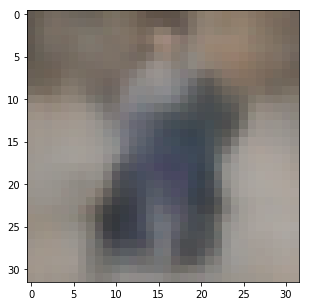

[[-0.27511585  0.95652467  0.05986924  0.12095077 -0.74056633  0.5860859
  -0.73786692  0.30959022 -0.71727098 -0.78231048 -0.62124896 -0.91103077
  -0.40785546  0.28957805 -0.50145493 -0.8360646   0.37169973 -0.77221075
   0.54657883  0.89132321  0.53924694 -0.28028198  0.13565128 -0.506381
  -0.10626693 -0.53584133  0.64206853 -0.12341748 -0.21696568 -0.96318384
  -0.10599344 -0.55482406 -0.7341528   0.19893092  0.28502204 -0.64924789
  -0.8963538   0.7414843   0.94330646 -0.19785626  0.52096995  0.5542962
   0.66359673  0.02321317  0.50429041  0.55255418 -0.75715715 -0.59472273
   0.10254918 -0.70184384  0.32028873  0.5534831  -0.40668077 -0.26112731
  -0.82409706 -0.85702233 -0.87666817 -0.70156566  0.74492483 -0.68090834]] 1


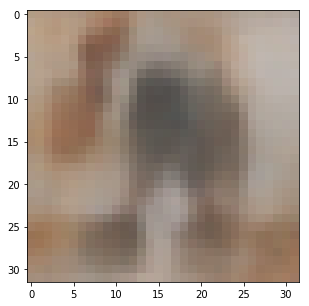

[[ 0.16374693  0.61435327 -0.12073566 -0.48669999 -0.75762715 -0.50998021
  -0.91019186  0.71055952 -0.16743378 -0.49659407  0.84830392 -0.82587327
   0.51815898  0.89462188  0.26705955 -0.31547294  0.9369031   0.45209283
   0.93627257 -0.2345997  -0.34312534  0.66276954 -0.69064299 -0.66843637
  -0.67042289 -0.1768432   0.06165246 -0.06681219 -0.79977098  0.96249539
   0.51780719 -0.68577537 -0.32693409 -0.37635907 -0.59462598  0.70498618
   0.22644029 -0.06299274  0.17520976 -0.15711639 -0.69369557 -0.44573179
  -0.67118132 -0.79630414 -0.86784492 -0.87909945 -0.00252505 -0.54792505
  -0.81420311 -0.36662896 -0.24006688 -0.25032276 -0.5895495  -0.75416141
  -0.38388958 -0.46632701  0.03426176 -0.99056522 -0.58075894 -0.09105094]] 1


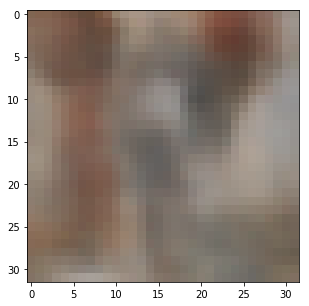

[[ 0.63414001  0.08964437  0.40522227 -0.42435472 -0.02908511 -0.91847488
   0.33597754  0.16088536 -0.10044074 -0.59012587  0.7858535   0.05088987
   0.29173475 -0.09196069  0.01538206 -0.16253191 -0.96633552 -0.86546507
   0.62352567 -0.7182288  -0.06645938 -0.10475795  0.61980915 -0.08297472
  -0.66319964 -0.03247968  0.68981038 -0.63187417 -0.63111643  0.14928991
   0.03212259  0.56790777 -0.41782964  0.16035905  0.69306746 -0.90084573
  -0.9101037   0.81848335  0.13092292 -0.22164969  0.63944946 -0.52776301
   0.94300907 -0.80357668  0.88747218  0.43535177 -0.10120032 -0.03922388
   0.14901365 -0.70050112 -0.00469439  0.63707876 -0.30191329  0.17873434
   0.51392844 -0.62953591 -0.13721422  0.13373619  0.14806515  0.65747403]] 1


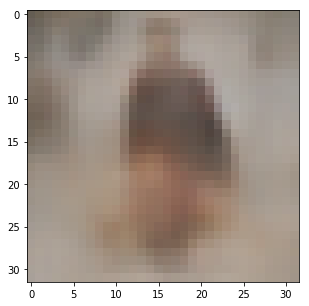

[[-0.69356279 -0.51086691 -0.98194637  0.11730536  0.05202491  0.47156535
   0.27342526  0.49146119  0.83252068  0.79893856 -0.06224937 -0.46220263
   0.48480536  0.37093837 -0.22282289  0.93027809 -0.9637849  -0.38300875
  -0.8818659   0.9448817  -0.88481501  0.84061796  0.48950911  0.61373526
   0.33974706  0.35351203 -0.90812215 -0.78129016  0.05823309 -0.2489443
   0.73366243 -0.15114191 -0.23159732  0.18698366  0.91852423 -0.65851412
   0.14714991  0.39069612  0.39112272 -0.44228922  0.01797167  0.97346402
  -0.1328414  -0.06560278 -0.72431015  0.87202754  0.69306822 -0.14812506
  -0.53137631  0.36790722 -0.5583264  -0.10803882 -0.79867588 -0.29505029
   0.06970006  0.19204242  0.07501551 -0.83910416 -0.82307259  0.36810707]] 1


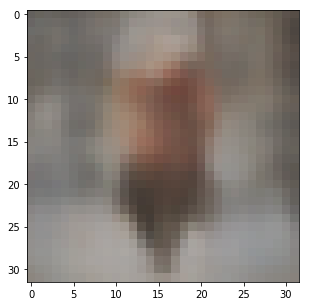

[[ 0.08039422  0.02446878 -0.84297286  0.34509752 -0.456541    0.73470419
  -0.0206122   0.37415869 -0.38521417 -0.8078515   0.50644935 -0.70478128
   0.04149552  0.37722849 -0.60375741 -0.16376003  0.2652757  -0.38734279
  -0.28163258 -0.52230144  0.75396064  0.00904608  0.3222314  -0.06634259
   0.17443635  0.60223058 -0.51008322 -0.68849006 -0.0191402  -0.19084059
  -0.97291736  0.41406408 -0.19736663  0.29447597  0.12496092  0.93125753
  -0.05108536 -0.32143334  0.40760819 -0.04934047 -0.00416538 -0.03511654
  -0.54257911 -0.67182279  0.77935517  0.74990148  0.80794803  0.66493567
  -0.44262921  0.15248784  0.57474681 -0.05773363 -0.82193607 -0.76296605
  -0.26820954  0.55123279  0.43591512 -0.62463499 -0.60128145  0.37232609]] 1


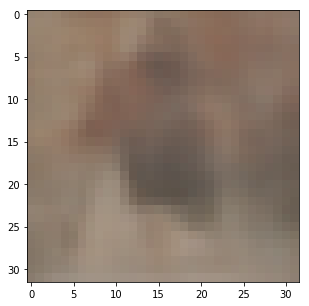

[[ 0.67216179  0.73177268 -0.60438425 -0.26634293 -0.67004812  0.07021251
   0.1654447  -0.6601438   0.89569809 -0.28732831  0.60355109  0.21304434
  -0.27574955 -0.39044151  0.84443159 -0.48223917 -0.73350476 -0.26884055
  -0.37466055 -0.47972747  0.17624517  0.16448423  0.39014269  0.57982495
  -0.980967   -0.20166456  0.80627168 -0.00527739 -0.51685593  0.52633916
   0.766471   -0.87262376 -0.73845928 -0.42449831 -0.89339509 -0.33128196
   0.06008687  0.17835508 -0.39539908  0.77421205  0.16648883 -0.05088972
  -0.50366699 -0.0520578   0.22423066  0.43295576 -0.25235714 -0.58318368
  -0.78454026  0.42663841  0.74553956 -0.622817   -0.42548701  0.90568801
  -0.34008878 -0.55780205 -0.00688893  0.08440563  0.16689831  0.85016851]] 1


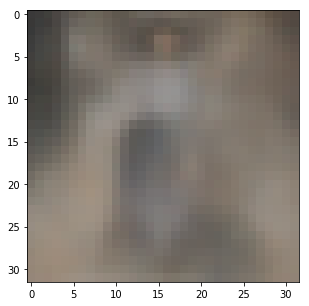

[[ 0.77394806 -0.33136411  0.18426365  0.55885051  0.24264844  0.66430331
   0.22636308  0.28760243  0.69069615  0.98022747  0.32240849  0.14770696
   0.75755037 -0.81353757  0.44053703  0.49951595 -0.18304133 -0.81040764
   0.02876325 -0.04226313  0.51631399  0.69202086 -0.99422028 -0.10258945
   0.59056604 -0.75050881  0.26696239  0.35863044  0.71088658  0.50989037
  -0.62440964 -0.59427517  0.96812196 -0.09421892 -0.23230212  0.52666502
   0.75257045  0.60751925  0.96192087  0.06423247 -0.07218822  0.15795024
  -0.32238123  0.48377394  0.49961913 -0.93051747  0.07848912 -0.57447217
  -0.7967421  -0.40092048 -0.53073704  0.55027058  0.56126642  0.01663208
  -0.42240421  0.20675941 -0.88167779  0.66106484  0.98959481 -0.28755253]] 1


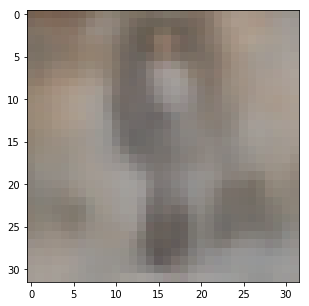

[[-0.12475273 -0.06255323 -0.83146241 -0.73320389 -0.71347455  0.84141701
   0.21404942  0.21124093  0.27161627  0.46095378 -0.01541731 -0.13827361
   0.71227739 -0.64648696  0.33291717 -0.15448803  0.06128732  0.64668408
   0.98939062  0.07825349  0.17708449  0.93673201 -0.368972    0.66267039
   0.80247032  0.88040791  0.43590333  0.79449576  0.28566169  0.96254257
  -0.05743814 -0.54474768  0.65408372  0.59758734  0.90563608  0.95999459
  -0.64183262 -0.85238304  0.33697016 -0.16147819  0.97970182 -0.8432784
   0.04112929 -0.98790556 -0.02861619 -0.88854597 -0.65051599 -0.49046111
   0.37608808  0.0466015   0.44562871  0.9628541   0.655364    0.74699277
  -0.11361277 -0.68860885 -0.0299071  -0.88686373  0.52536221  0.80539058]] 1


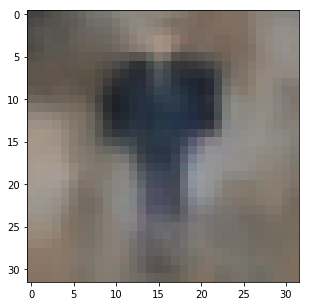

[[-0.95407928 -0.95673321  0.64263283  0.83402203 -0.21131236 -0.09966981
   0.32585735 -0.02346175 -0.28218937 -0.65515282  0.99536796  0.47029421
  -0.63020829 -0.85499791 -0.08288714  0.30034319 -0.99679535  0.09576242
  -0.36263993 -0.0205388   0.9630801  -0.30264017  0.48927786  0.95337391
   0.73346257  0.59585616 -0.31223133  0.97660464  0.02019473 -0.41053661
   0.44288407 -0.27275843 -0.58647281  0.84918137  0.81572728 -0.88846864
   0.70019849  0.78697457 -0.62291347 -0.69568191  0.887088    0.92538845
   0.1839821   0.84713883  0.76873809 -0.92186892 -0.20853849 -0.30478637
   0.36309165  0.97022678  0.0020083  -0.65212553 -0.28721305  0.94175382
   0.82699865  0.77957044 -0.5366214  -0.55120201 -0.7203646   0.12742263]] 1


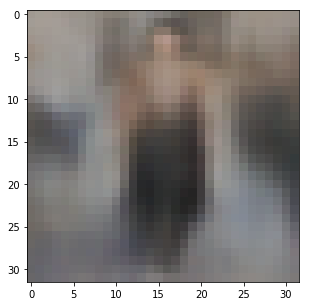

[[-0.75595078 -0.41000303 -0.87233052 -0.16983269 -0.11296713 -0.63110899
   0.00839224 -0.0412091  -0.92714591 -0.59528462  0.88356608 -0.99467709
   0.71199932  0.91792763 -0.11127035 -0.97208648  0.28198627 -0.47905705
   0.28535449 -0.06252116  0.40669367  0.84710861  0.35606557 -0.47245615
  -0.66373257 -0.00417078  0.80387359  0.61264273  0.12727917  0.18229333
  -0.98960176  0.0106468   0.679314    0.39119304  0.01748568  0.14504521
  -0.24602187 -0.78115425 -0.5638671  -0.30134189  0.67830515 -0.56660156
   0.48148959  0.73768756  0.68404276 -0.32280622  0.63765967  0.59739499
  -0.36627341 -0.85257182  0.85304994 -0.47859385  0.75277604 -0.85506483
  -0.81484623 -0.22861048  0.13986613 -0.58405995 -0.53593172  0.23805676]] 1


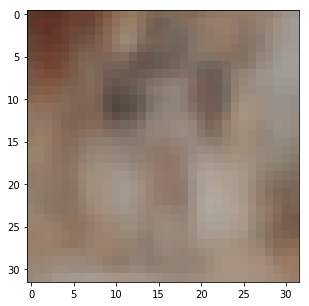

[[-0.55642678 -0.59149242 -0.99262221 -0.41623774  0.67820476  0.64283803
   0.46558121  0.72360998  0.2753067  -0.30438376  0.61620162  0.10206997
  -0.62954038  0.73350045 -0.75485163 -0.04193037  0.7297532   0.61151838
   0.82410024  0.06048239 -0.43488222 -0.57634946  0.6725731  -0.33594937
  -0.60514786 -0.45343084 -0.11783931  0.89739154  0.10163949  0.56184188
   0.72143437  0.18053527 -0.69829236  0.24571276  0.16091299  0.30852207
  -0.88479292  0.99512453 -0.0032326   0.30885946 -0.80479607  0.83139111
   0.10849749 -0.71028456 -0.75190632 -0.99259984 -0.52047729 -0.69262121
  -0.01957276  0.30930381  0.28122247 -0.14727769 -0.82206262 -0.00982006
   0.48991406 -0.25844118  0.20538221  0.46937756 -0.38604581  0.66565602]] 1


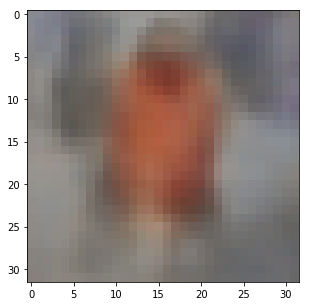

[[-0.7447791   0.0614483  -0.27891961 -0.55445889  0.6952157   0.52026282
   0.81481412 -0.38501906  0.39958485  0.70082788  0.57784049  0.22857985
   0.00901197  0.38444992  0.65988912 -0.17172764  0.89866985  0.93318342
  -0.52785531  0.12441433  0.57040268 -0.03072583  0.57096541 -0.96871084
   0.74117235  0.38328332 -0.36981834 -0.63531612  0.8122676   0.2350774
  -0.23513838  0.09294906 -0.82844316  0.28707182 -0.92948418  0.40756666
  -0.86804113  0.24308899  0.50800705  0.05750776  0.49812095  0.26772885
  -0.21742073 -0.99136907 -0.22932928 -0.15473551  0.13194031  0.94383011
   0.42767109  0.1547046   0.01861912  0.78398477 -0.2758162   0.37719731
   0.38258316  0.57172415 -0.39228305  0.73809681  0.699011   -0.00524376]] 1


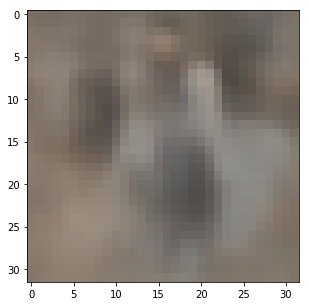

[[-0.57555214 -0.77653621  0.48131106 -0.50673094 -0.15507281  0.39851417
  -0.14066917  0.09701483 -0.07363959 -0.89776377  0.76680091  0.10069565
   0.87581912  0.02567913  0.09505116 -0.99474703 -0.1040354  -0.37077644
   0.98703671 -0.47443088  0.95273511 -0.19229874 -0.05096533 -0.08989333
   0.8884895   0.69071768 -0.69156636 -0.76908609 -0.86624906  0.40580433
   0.20449037  0.53179667  0.69599786  0.23371371 -0.58941164 -0.06463564
  -0.03595222  0.2522814   0.48627771 -0.31097304  0.93548283  0.09265015
   0.30060342 -0.63497215 -0.8586135   0.43284983 -0.57620629  0.24155237
  -0.0031543  -0.35562026  0.98587022 -0.93631895 -0.27845008 -0.53294384
   0.97127887  0.04011073  0.14163969  0.03781812  0.26178059 -0.5302697 ]] 1


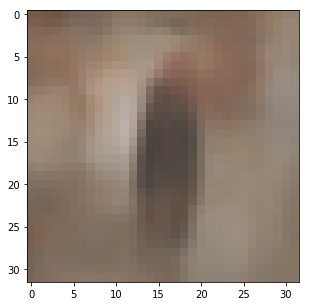

[[ 0.58093243 -0.05604069 -0.586874   -0.47171674  0.2044217   0.34888599
   0.15990229 -0.89046886  0.33380701  0.92454236 -0.25466493  0.24023772
   0.0583345   0.00928028 -0.71623676 -0.54231389 -0.81127305  0.10877401
  -0.75103198 -0.84242633 -0.66176736 -0.89907441 -0.62594099 -0.87350371
  -0.16343472  0.83142515  0.24933401  0.44926515  0.36696587  0.26696816
   0.28463085 -0.37451006 -0.12985437  0.41147732 -0.09622553 -0.22626008
  -0.6867565   0.52106676 -0.04333705 -0.37426116  0.87300055 -0.80364105
  -0.6790143  -0.50922344 -0.22943536  0.29905629 -0.58359122  0.40551973
  -0.48637113 -0.57255118  0.96745735 -0.15172213  0.30464887 -0.23224103
   0.28176399 -0.92036102  0.38449174 -0.85185014 -0.5161746   0.78704679]] 1


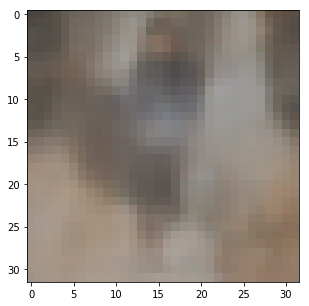

[[-0.1260479  -0.56797765 -0.91282617  0.77911363 -0.89488022  0.8933356
  -0.86381259  0.6706937  -0.19323497  0.66014835  0.07781785  0.51425516
   0.92024169  0.64518732  0.5462139   0.85577279  0.48015729  0.0993535
  -0.99622969  0.3594654   0.45010675 -0.21289612  0.34238398 -0.41845394
   0.10680575  0.77161845 -0.45458062 -0.29833452 -0.54683648 -0.0254753
   0.2252367   0.64407226 -0.37846595  0.26920765  0.82688546  0.92679354
   0.76174307  0.42815651  0.28343215  0.43639202  0.80215364  0.39176511
   0.2734835  -0.44787156  0.31170787  0.04068801 -0.01500465 -0.23430851
   0.89909771 -0.36796923 -0.12071946 -0.89624428  0.41334561 -0.3226702
  -0.02412786  0.0552427   0.4454649  -0.189089   -0.0400485  -0.45244717]] 1


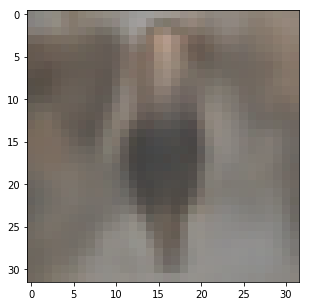

[[-0.00173617 -0.15248965 -0.79527097 -0.58051247  0.54130037 -0.15256231
   0.45658062 -0.4968985  -0.21639854 -0.96778335 -0.51308545 -0.47637442
  -0.87490938  0.90279907 -0.90468887  0.07041227  0.45179181 -0.517038
   0.25442125  0.32304206  0.28250071  0.38582052 -0.90983275  0.71745929
   0.47065643 -0.86660223 -0.29676684 -0.20267615 -0.99022196 -0.559758
  -0.84759276  0.76918595  0.15920924  0.62839361  0.66000768 -0.39893072
   0.59730034  0.40312426 -0.57034217  0.86828616  0.68496339  0.30044343
  -0.4707818   0.02788663  0.44236078 -0.87055735  0.81440725  0.94147057
  -0.52727266  0.25933035 -0.56891792  0.02930699  0.85309941 -0.94353698
  -0.96819415 -0.77862819 -0.36002828 -0.9221301   0.48673841  0.45325997]] 1


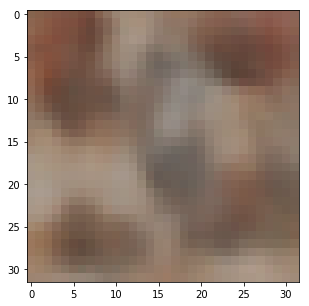

[[ 0.18384501  0.57621383  0.55826623 -0.47337218  0.74713357 -0.56051676
  -0.84209159  0.94909934  0.99364963 -0.48221579 -0.37267456 -0.22797702
  -0.76299161  0.20909166  0.59916702  0.27005032 -0.17997844 -0.17268429
  -0.47840178  0.92468221 -0.56046864 -0.17909987 -0.19611801  0.58384518
  -0.05377097 -0.06162169 -0.97121379 -0.9600431  -0.53264814  0.78771667
   0.0644694   0.09398448 -0.8814476   0.498545   -0.18158582  0.17864256
   0.60949349 -0.34864315 -0.86614433 -0.86063494 -0.72856744  0.42224726
  -0.38562344 -0.70991896  0.19828434 -0.40956147 -0.23130504 -0.54406293
   0.94918256 -0.18613811  0.38902307 -0.68330028  0.61663231 -0.51388409
  -0.36617507 -0.2985503   0.60348572  0.51415794 -0.01543411  0.83166659]] 1


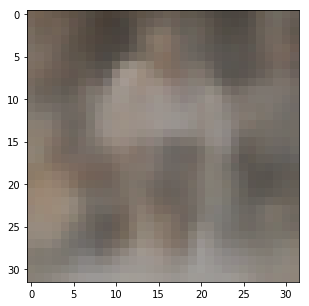

[[-0.92248668  0.77974528  0.30610483  0.50397938 -0.73095696  0.5033276
   0.9079724  -0.04808456 -0.99065318 -0.87321314 -0.79115572  0.17418445
  -0.72001164 -0.72722791 -0.77206675 -0.08090547 -0.16310186 -0.07779473
  -0.40415101  0.54979743 -0.61101232 -0.64422703  0.39182335 -0.61853477
   0.95890132  0.87471557 -0.14456412  0.63235618 -0.302087    0.59833697
  -0.1313045   0.49806099 -0.19944991 -0.55642406  0.8744764  -0.82763132
   0.01475207  0.90418005  0.51622144  0.84282644  0.27854651  0.93305242
   0.72844588 -0.32451459 -0.48106684  0.85744345 -0.03474128  0.88249481
  -0.65697342 -0.85429427  0.18493275 -0.32857113 -0.84548166 -0.35165641
   0.21360683  0.40868191  0.83709288 -0.6318239  -0.84039506  0.93344743]] 1


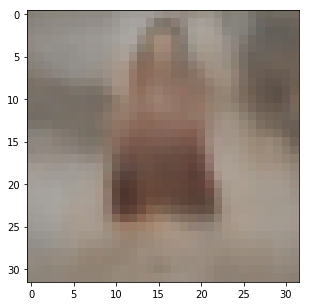

[[-0.11336148  0.29451728  0.31434082  0.09196443  0.73309473  0.91173677
  -0.2015974   0.74140476  0.34509715 -0.81654605 -0.39978408  0.73600564
  -0.6331155  -0.30517279  0.45512093 -0.89252752 -0.95090579 -0.55630809
  -0.42199297  0.9085624  -0.82938912  0.13325927  0.92648898 -0.08273759
   0.3099251   0.67714575 -0.50526829 -0.86843233 -0.65889115  0.57443061
   0.54002695  0.22046165 -0.85500038 -0.8587535  -0.39507217 -0.0690203
  -0.86599878  0.79375037  0.85701221 -0.33867988 -0.65413389 -0.23250646
   0.89782975 -0.82513947 -0.98239979 -0.68137281  0.12706077 -0.05256521
   0.74767305  0.04317827 -0.63088039 -0.07579735 -0.80295777  0.66471563
  -0.03555396  0.7671934   0.66993442 -0.47116066 -0.84745493 -0.45385157]] 1


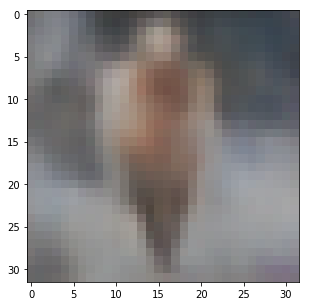

[[ 0.18633461  0.30441539 -0.69890356  0.04686928 -0.20333323  0.99251142
  -0.10164512 -0.72869863  0.85622496 -0.4999191  -0.87816844  0.06756854
  -0.94431583  0.12942683  0.28182475 -0.42425526 -0.91290281 -0.23065178
  -0.68472347 -0.29557114 -0.37051328 -0.09231297  0.85166696 -0.48780959
  -0.89831151  0.89837612  0.26098431  0.41691215 -0.27371399 -0.75064833
   0.31159017  0.12201977 -0.88516354  0.10166399 -0.12869419  0.94472688
  -0.30572023 -0.91296344 -0.86377677 -0.18156686 -0.62150648  0.70366702
   0.71902504  0.21200121  0.13462852 -0.11021444  0.61271185  0.22113273
   0.31708007 -0.29406052 -0.4842654   0.68336996  0.98651961 -0.76833581
   0.75627049  0.12056807 -0.50582154 -0.19495251  0.94841478  0.71707742]] 1


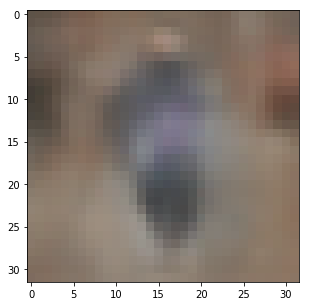

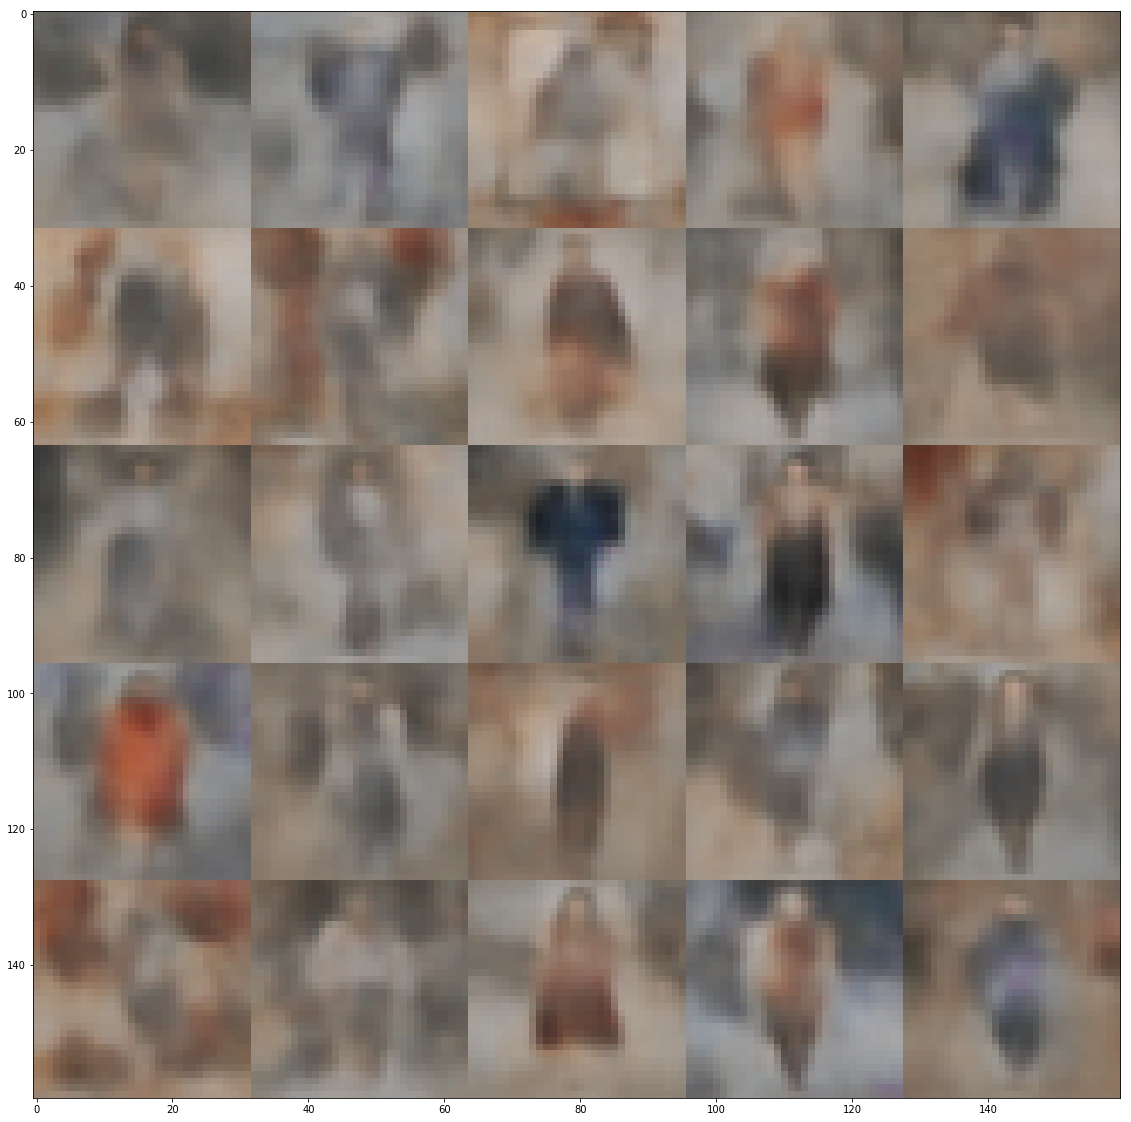

In [6]:
# display images generated from randomly sampled latent vector
n = 5
figure = np.zeros((img_cols * n, img_rows * n, img_chns))


for i in range(n):
    for j in range(n):
        #z_sample = [1] * (latent_dim-1)
        #z_sample.extend([-1])
        #z_sample = np.array([z_sample])
        z_sample = np.array([np.random.uniform(-1,1,size=latent_dim)])
        print(z_sample, len(z_sample))
        x_decoded = generator.predict(z_sample)
        img = x_decoded[0].reshape(img_cols, img_rows, img_chns)
        #print(img)
        figure[i * img_cols: (i + 1) * img_cols, j * img_rows: (j + 1) * img_rows] = img

        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.show()


plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='Greys_r')
#plt.imshow(figure)
#plt.show()